# Business Growth Radar Chart

## Import Data Source

In [244]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [245]:
as_week = 2023025
data_src = f"../../data/raw/Raw-Agg Perf_Wk_Area {as_week}.csv"
df_bg = pd.read_csv(data_src)

cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'METRIC_CD', 'METRIC_NAME', 'ARAE_NO', 'AREA_TYPE', 'AREA_CD', 'AREA_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df_bg = df_bg[cols]
df_bg.head(3)

C:\Users\Narut4\AppData\Local\Temp\ipykernel_19304\4063908837.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bg = pd.read_csv(data_src)


,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,METRIC_CD,METRIC_NAME,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,PPN_TM
0,20230301,2023009,202303,20231,2023,B2R000100,Postpaid Revenue,3,H,038,"BKK : Lat Phrao, Wang Thonglang",S,72255.4257,72255.4257,70927.3896,70927.3896,2023-06-28 17:48:36
1,20230301,2023009,202303,20231,2023,B2R000100,Postpaid Revenue,3,H,20A,Chonburi 1,S,141750.6124,141750.6124,91689.5586,91689.5586,2023-06-28 17:48:36
2,20230301,2023009,202303,20231,2023,B2R000100,Postpaid Revenue,3,H,64Y,Sukhothai - Uttaradit,S,35168.0219,35168.0219,68022.5956,68022.5956,2023-06-28 17:48:36


In [246]:
df_bg.shape

(67860, 17)

In [247]:
df_bg['METRIC_NAME'].unique()

array(['Postpaid Revenue', 'Prepaid Revenue',
       'TDG Revenue (Performance View)', 'TOL Revenue', 'TVS Revenue'],
      dtype=object)

## Data Preporation

In [248]:
''' Dict '''

weight_dict = {'Prepaid Revenue': 0.28, 
               'Postpaid Revenue': 0.45, 
               'TOL Revenue': 0.12, 
               'TVS Revenue': 0.04, 
               'TDG Revenue (Performance View)': 0.02}

# score_dict = {1: 0.8, 
#               2: 0.9, 
#               3: 1, 
#               4: 1.1, 
#               5: 1.2}

score_dict = {1: 0.7, 
              2: 0.8, 
              3: 0.9, 
              4: 1, 
              5: 1.2}

In [249]:
''' Functions '''


def unit_mb(baht):
    n = baht

    unit_mb = n / 1000000
    
    return unit_mb


def weight_score(achv):
    n = achv
    score = 0

    if n < score_dict[1]: score = 1 
    elif n < score_dict[2]: score = (n-score_dict[1]) / (score_dict[2]-score_dict[1]) + 1
    elif n < score_dict[3]: score = (n-score_dict[2]) / (score_dict[3]-score_dict[2]) + 2
    elif n < score_dict[4]: score = (n-score_dict[3]) / (score_dict[4]-score_dict[3]) + 3
    elif n < score_dict[5]: score = (n-score_dict[4]) / (score_dict[5]-score_dict[4]) + 4
    elif n >= score_dict[5]: score = 5
    else: score = 0

    return score

In [250]:
''' Rawdata '''

''' Filters '''
# df_bg = df_bg[df_bg['TM_KEY_MTH'] <= 202306] # MONTH filter
# df_bg = df_bg[df_bg['TM_KEY_WK'] <= 2023025] # WEEK filter
# df_bg = df_bg[df_bg['TM_KEY_DAY'] <= 20230620] # DAY filter
df_bg = df_bg[~(df_bg['AREA_NAME'].isin(['Unidentified', 'True Corp']))] # Area filter

''' Modify '''
df_bg = df_bg.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})

''' Add new column '''
df_bg['MTH_DESC'] = pd.to_datetime(df_bg['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df_bg['WK_LABEL'] = df_bg['TM_KEY_WK'].apply(str).str[5:].astype(int)
df_bg['DAY_LABEL'] = df_bg['TM_KEY_DAY'].apply(str).str[6:].astype(int)

In [251]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df_bg[df_bg['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df_bg[df_bg['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')

In [252]:
''' Period Values '''

curr_yr = df_bg['TM_KEY_YR'].max()
last_yr = df_bg['TM_KEY_YR'].max() - 1
curr_mth = df_bg['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df_bg['TM_KEY_WK'].max()
last_wk = df_bg['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df_bg['WK_LABEL'].iloc[-1]
curr_day = df_bg['TM_KEY_DAY'].max()
last_day = df_bg['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df_bg['DAY_LABEL'].iloc[-1]
last_ppn_tm = df_bg['PPN_TM'].max()

wk_day_start = int(str(df_bg[df_bg['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df_bg[df_bg['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

## ** Yearly **

### YR : Aggregation

In [271]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'ARAE_NO', 'AREA_TYPE', 'AREA_CD', 'AREA_NAME', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby(['METRIC_CD', 'AREA_CD', 'TM_KEY_YR'])['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'ARAE_NO', 'AREA_TYPE', 'AREA_CD', 'AREA_NAME', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' YTD '''
df_rev_yr = df_rev_yr[df_rev_yr['TM_KEY_YR']==curr_yr]
df_rev_yr = df_rev_yr[df_rev_yr['AREA_TYPE'].isin(['P', 'G', 'H'])]
# df_rev_yr = df_rev_yr[df_rev_yr['AREA_TYPE']=='P']
# df_rev_yr[df_rev_yr['METRIC_NAME']=='TDG Revenue (Performance View)']

''' Aggregation '''
df_rev_yr['BASELINE'] = df_rev_yr.groupby(['METRIC_CD', 'AREA_CD'])['ACT_SNAP'].shift().fillna(0)
df_rev_yr['%ACHV'] = (df_rev_yr['ACT_SNAP']-df_rev_yr['BASELINE']) / (df_rev_yr['TGT_SNAP']-df_rev_yr['BASELINE'])
df_rev_yr['%ACHV'] = np.where(df_rev_yr['%ACHV'] < 1.2, df_rev_yr['%ACHV'], 1.2)
df_rev_yr['WEIGHT'] = df_rev_yr['METRIC_NAME'].map(weight_dict)
df_rev_yr['WEIGHT_ACT'] = df_rev_yr['%ACHV'] * df_rev_yr['WEIGHT']

df_rev_yr.head()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
0,B1R000100,Prepaid Revenue,2023,1,P,P,Nationwide,S,1.399277e+10,1.405931e+10,0.0,0.995267,0.28,0.278675
1,B1R000100,Prepaid Revenue,2023,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,1.507201e+09,1.552658e+09,0.0,0.970723,0.28,0.271802
2,B1R000100,Prepaid Revenue,2023,2,G,GX2,Regional Management 2 (BMA-East),S,1.693634e+09,1.616087e+09,0.0,1.047985,0.28,0.293436
3,B1R000100,Prepaid Revenue,2023,2,G,GX3,Retail Management & Regional Management 3 (East),S,2.490063e+09,2.480543e+09,0.0,1.003838,0.28,0.281075
4,B1R000100,Prepaid Revenue,2023,2,G,GX4,Regional Management 4 (North),S,1.929580e+09,1.856620e+09,0.0,1.039297,0.28,0.291003


In [254]:
df_rev_yr[df_rev_yr['AREA_TYPE']=='P']

,METRIC_CD,METRIC_NAME,TM_KEY_YR,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
0,B1R000100,Prepaid Revenue,2023,1,P,P,Nationwide,S,1.399277e+10,1.405931e+10,0.0,0.995267,0.28,0.278675
114,B2R000100,Postpaid Revenue,2023,1,P,P,Nationwide,S,2.529317e+10,2.561275e+10,0.0,0.987523,0.45,0.444385
228,TB3R000100,TOL Revenue,2023,1,P,P,Nationwide,S,5.508463e+09,5.877324e+09,0.0,0.937240,0.12,0.112469
342,TB4R000100,TVS Revenue,2023,1,P,P,Nationwide,S,1.140805e+09,1.490026e+09,0.0,0.765628,0.04,0.030625
39952,TNSC00142,TDG Revenue (Performance View),2023,1,P,P,Nationwide,N,5.180000e+08,4.600000e+08,0.0,1.126087,0.02,0.022522


In [255]:
df_rev_yr[df_rev_yr['AREA_CD']=='GX1']

,METRIC_CD,METRIC_NAME,TM_KEY_YR,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
1,B1R000100,Prepaid Revenue,2023,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,1.507201e+09,1.552658e+09,0.0,0.970723,0.28,0.271802
115,B2R000100,Postpaid Revenue,2023,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,3.748527e+09,3.780847e+09,0.0,0.991452,0.45,0.446153
229,TB3R000100,TOL Revenue,2023,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,1.034601e+09,1.130674e+09,0.0,0.915030,0.12,0.109804
343,TB4R000100,TVS Revenue,2023,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,2.513987e+08,2.975523e+08,0.0,0.844889,0.04,0.033796


In [256]:
df_rev_yr[df_rev_yr['AREA_CD']=='001']

,METRIC_CD,METRIC_NAME,TM_KEY_YR,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
9,B1R000100,Prepaid Revenue,2023,3,H,001,"BKK : Phra Nakhon, Dusit",S,4.667392e+07,6.809881e+07,0.0,0.685385,0.28,0.191908
123,B2R000100,Postpaid Revenue,2023,3,H,001,"BKK : Phra Nakhon, Dusit",S,1.288749e+08,1.940360e+08,0.0,0.664180,0.45,0.298881
237,TB3R000100,TOL Revenue,2023,3,H,001,"BKK : Phra Nakhon, Dusit",S,2.535584e+07,2.792559e+07,0.0,0.907978,0.12,0.108957
351,TB4R000100,TVS Revenue,2023,3,H,001,"BKK : Phra Nakhon, Dusit",S,9.781547e+06,1.175823e+07,0.0,0.831890,0.04,0.033276


In [257]:
''' YTD Dataframe '''

df_ytd_bg_score = pd.DataFrame(df_rev_yr.groupby(['ARAE_NO', 'AREA_TYPE', 'AREA_CD', 'AREA_NAME'])\
    .agg({'ACT_SNAP':'sum', 'TGT_SNAP':'sum', 'WEIGHT_ACT':'sum', 'WEIGHT':'sum'})).reset_index()
    
df_ytd_bg_score['%ACHV'] = df_ytd_bg_score['WEIGHT_ACT'] / df_ytd_bg_score['WEIGHT']
df_ytd_bg_score['SCORE'] = df_ytd_bg_score['%ACHV'].apply(lambda x: weight_score(x))

df_ytd_bg_score.sort_values(['ARAE_NO', 'AREA_TYPE', 'AREA_CD'])

# df_ytd_bg_score.to_excel('df_ytd_bg_score.xlsx', index=False)

,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,ACT_SNAP,TGT_SNAP,WEIGHT_ACT,WEIGHT,%ACHV,SCORE
0,1,P,P,Nationwide,4.645320e+10,4.749940e+10,0.888676,0.91,0.976567,3.765667
1,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),6.541728e+09,6.761731e+09,0.861555,0.89,0.968039,3.680393
2,2,G,GX2,Regional Management 2 (BMA-East),8.811378e+09,9.054694e+09,0.877238,0.89,0.985661,3.856608
3,2,G,GX3,Retail Management & Regional Management 3 (East),7.626910e+09,7.829784e+09,0.864345,0.89,0.971175,3.711747
4,2,G,GX4,Regional Management 4 (North),5.033022e+09,4.979603e+09,0.893456,0.89,1.003883,4.019417
...,...,...,...,...,...,...,...,...,...,...
109,3,H,92Y,Trang - Satun,3.985854e+08,4.976702e+08,0.722466,0.89,0.811759,2.117592
110,3,H,93Z,Phatthalung,1.611403e+08,2.637957e+08,0.581619,0.89,0.653505,1.000000
111,3,H,94Z,Pattani,1.362724e+08,2.214256e+08,0.567080,0.89,0.637169,1.000000
112,3,H,95Z,Yala,1.019468e+08,2.118406e+08,0.482561,0.89,0.542203,1.000000


### YR : Visualizations

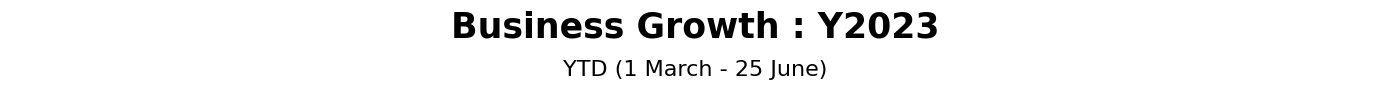

In [258]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Business Growth : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [272]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'ARAE_NO', 'AREA_TYPE', 'AREA_CD', 'AREA_NAME', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby(['METRIC_CD', 'AREA_CD', 'TM_KEY_MTH'])['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'ARAE_NO', 'AREA_TYPE', 'AREA_CD', 'AREA_NAME', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' MTD '''
df_rev_mth = df_rev_mth[df_rev_mth['TM_KEY_MTH']==curr_mth]
df_rev_mth = df_rev_mth[df_rev_mth['AREA_TYPE'].isin(['P', 'G', 'H'])]

''' Aggregation '''
df_rev_mth['BASELINE'] = df_rev_mth.groupby(['METRIC_CD', 'AREA_CD'])['ACT_SNAP'].shift().fillna(0)
df_rev_mth['%ACHV'] = (df_rev_mth['ACT_SNAP']-df_rev_mth['BASELINE']) / (df_rev_mth['TGT_SNAP']-df_rev_mth['BASELINE'])
df_rev_mth['%ACHV'] = np.where(df_rev_mth['%ACHV'] < 1.2, df_rev_mth['%ACHV'], 1.2)
df_rev_mth['WEIGHT'] = df_rev_mth['METRIC_NAME'].map(weight_dict)
df_rev_mth['WEIGHT_ACT'] = df_rev_mth['%ACHV'] * df_rev_mth['WEIGHT']

df_rev_mth.head()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
342,B1R000100,Prepaid Revenue,202306,June,1,P,P,Nationwide,S,2.990800e+09,3.036514e+09,0.0,0.984945,0.28,0.275785
343,B1R000100,Prepaid Revenue,202306,June,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,3.221213e+08,3.344257e+08,0.0,0.963207,0.28,0.269698
344,B1R000100,Prepaid Revenue,202306,June,2,G,GX2,Regional Management 2 (BMA-East),S,3.686437e+08,3.481175e+08,0.0,1.058963,0.28,0.296510
345,B1R000100,Prepaid Revenue,202306,June,2,G,GX3,Retail Management & Regional Management 3 (East),S,5.321612e+08,5.369643e+08,0.0,0.991055,0.28,0.277495
346,B1R000100,Prepaid Revenue,202306,June,2,G,GX4,Regional Management 4 (North),S,4.153625e+08,4.151497e+08,0.0,1.000513,0.28,0.280144


In [260]:
df_rev_mth[df_rev_mth['AREA_TYPE']=='P']

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
342,B1R000100,Prepaid Revenue,202306,June,1,P,P,Nationwide,S,2.990800e+09,3.036514e+09,0.0,0.984945,0.28,0.275785
798,B2R000100,Postpaid Revenue,202306,June,1,P,P,Nationwide,S,5.453242e+09,5.649574e+09,0.0,0.965248,0.45,0.434362
1254,TB3R000100,TOL Revenue,202306,June,1,P,P,Nationwide,S,1.272108e+09,1.356828e+09,0.0,0.937560,0.12,0.112507
1710,TB4R000100,TVS Revenue,202306,June,1,P,P,Nationwide,S,2.187610e+08,2.491767e+08,0.0,0.877935,0.04,0.035117
39952,TNSC00142,TDG Revenue (Performance View),202306,June,1,P,P,Nationwide,N,5.180000e+08,4.600000e+08,0.0,1.126087,0.02,0.022522


In [261]:
df_rev_mth[df_rev_mth['AREA_CD']=='GX1']

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
343,B1R000100,Prepaid Revenue,202306,June,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,3.221213e+08,3.344257e+08,0.0,0.963207,0.28,0.269698
799,B2R000100,Postpaid Revenue,202306,June,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,7.978704e+08,8.356581e+08,0.0,0.954781,0.45,0.429651
1255,TB3R000100,TOL Revenue,202306,June,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,2.345508e+08,2.610252e+08,0.0,0.898575,0.12,0.107829
1711,TB4R000100,TVS Revenue,202306,June,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,4.460256e+07,4.977893e+07,0.0,0.896013,0.04,0.035841


In [262]:
df_rev_mth[df_rev_mth['AREA_CD']=='001']

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
351,B1R000100,Prepaid Revenue,202306,June,3,H,001,"BKK : Phra Nakhon, Dusit",S,1.009337e+07,1.460106e+07,0.0,0.691276,0.28,0.193557
807,B2R000100,Postpaid Revenue,202306,June,3,H,001,"BKK : Phra Nakhon, Dusit",S,2.787080e+07,4.242673e+07,0.0,0.656916,0.45,0.295612
1263,TB3R000100,TOL Revenue,202306,June,3,H,001,"BKK : Phra Nakhon, Dusit",S,5.751549e+06,6.446849e+06,0.0,0.892149,0.12,0.107058
1719,TB4R000100,TVS Revenue,202306,June,3,H,001,"BKK : Phra Nakhon, Dusit",S,1.619629e+06,1.966877e+06,0.0,0.823452,0.04,0.032938


In [263]:
''' MTD Dataframe '''

df_mtd_bg_score = pd.DataFrame(df_rev_mth.groupby(['ARAE_NO', 'AREA_TYPE', 'AREA_CD', 'AREA_NAME'])\
    .agg({'ACT_SNAP':'sum', 'TGT_SNAP':'sum', 'WEIGHT_ACT':'sum', 'WEIGHT':'sum'})).reset_index()
    
df_mtd_bg_score['%ACHV'] = df_mtd_bg_score['WEIGHT_ACT'] / df_mtd_bg_score['WEIGHT']
df_mtd_bg_score['SCORE'] = df_mtd_bg_score['%ACHV'].apply(lambda x: weight_score(x))

df_mtd_bg_score.sort_values(['ARAE_NO', 'AREA_TYPE', 'AREA_CD'])

# df_mtd_bg_score.to_excel('df_mtd_bg_score.xlsx', index=False)

,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,ACT_SNAP,TGT_SNAP,WEIGHT_ACT,WEIGHT,%ACHV,SCORE
0,1,P,P,Nationwide,1.045291e+10,1.075209e+10,0.880293,0.91,0.967355,3.673547
1,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),1.399145e+09,1.480888e+09,0.843019,0.89,0.947212,3.472123
2,2,G,GX2,Regional Management 2 (BMA-East),1.897402e+09,1.986502e+09,0.864117,0.89,0.970917,3.709174
3,2,G,GX3,Retail Management & Regional Management 3 (East),1.642283e+09,1.693844e+09,0.861028,0.89,0.967448,3.674476
4,2,G,GX4,Regional Management 4 (North),1.093125e+09,1.111650e+09,0.872258,0.89,0.980065,3.800655
...,...,...,...,...,...,...,...,...,...,...
109,3,H,92Y,Trang - Satun,8.495298e+07,1.073664e+08,0.716618,0.89,0.805189,2.051885
110,3,H,93Z,Phatthalung,3.479510e+07,5.715759e+07,0.582550,0.89,0.654551,1.000000
111,3,H,94Z,Pattani,2.851696e+07,4.749968e+07,0.557887,0.89,0.626839,1.000000
112,3,H,95Z,Yala,2.188765e+07,4.536915e+07,0.483212,0.89,0.542935,1.000000


### MTH : Visualizations

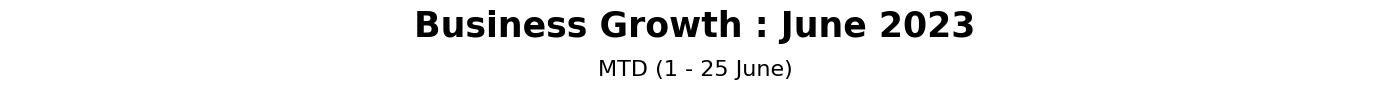

In [264]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Business Growth : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

## ** Weekly **

### WK : Aggregation

In [273]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'ARAE_NO', 'AREA_TYPE', 'AREA_CD', 'AREA_NAME', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum', 'DAY_LABEL': 'min'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'ARAE_NO', 'AREA_TYPE', 'AREA_CD', 'AREA_NAME', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

''' WTD '''
df_rev_wk = df_rev_wk[df_rev_wk['TM_KEY_WK']==curr_wk]
df_rev_wk = df_rev_wk[df_rev_wk['AREA_TYPE'].isin(['P', 'G', 'H'])]

''' Aggregation '''
df_rev_wk['BASELINE'] = df_rev_wk.groupby(['METRIC_CD', 'AREA_CD'])['ACT_SNAP'].shift().fillna(0)
df_rev_wk['%ACHV'] = (df_rev_wk['ACT_SNAP']-df_rev_wk['BASELINE']) / (df_rev_wk['TGT_SNAP']-df_rev_wk['BASELINE'])
df_rev_wk['%ACHV'] = np.where(df_rev_wk['%ACHV'] < 1.2, df_rev_wk['%ACHV'], 1.2)
df_rev_wk['WEIGHT'] = df_rev_wk['METRIC_NAME'].map(weight_dict)
df_rev_wk['WEIGHT_ACT'] = df_rev_wk['%ACHV'] * df_rev_wk['WEIGHT']

df_rev_wk.head()

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,DAY_LABEL,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
1824,B1R000100,Prepaid Revenue,2023025,25,1,P,P,Nationwide,S,8.177526e+08,8.362708e+08,19.0,0.0,0.977856,0.28,0.273800
1825,B1R000100,Prepaid Revenue,2023025,25,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,8.724086e+07,9.201448e+07,19.0,0.0,0.948121,0.28,0.265474
1826,B1R000100,Prepaid Revenue,2023025,25,2,G,GX2,Regional Management 2 (BMA-East),S,1.021758e+08,9.576114e+07,19.0,0.0,1.066986,0.28,0.298756
1827,B1R000100,Prepaid Revenue,2023025,25,2,G,GX3,Retail Management & Regional Management 3 (East),S,1.471204e+08,1.476658e+08,19.0,0.0,0.996307,0.28,0.278966
1828,B1R000100,Prepaid Revenue,2023025,25,2,G,GX4,Regional Management 4 (North),S,1.119823e+08,1.144970e+08,19.0,0.0,0.978037,0.28,0.273850


In [266]:
df_rev_wk[df_rev_wk['AREA_TYPE']=='P']

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,DAY_LABEL,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
1824,B1R000100,Prepaid Revenue,2023025,25,1,P,P,Nationwide,S,8.177526e+08,8.362708e+08,19.0,0.0,0.977856,0.28,0.273800
3762,B2R000100,Postpaid Revenue,2023025,25,1,P,P,Nationwide,S,1.676599e+09,1.728768e+09,19.0,0.0,0.969823,0.45,0.436420
5700,TB3R000100,TOL Revenue,2023025,25,1,P,P,Nationwide,S,4.418305e+08,4.778610e+08,19.0,0.0,0.924600,0.12,0.110952
7638,TB4R000100,TVS Revenue,2023025,25,1,P,P,Nationwide,S,7.525319e+07,8.592026e+07,19.0,0.0,0.875849,0.04,0.035034
39952,TNSC00142,TDG Revenue (Performance View),2023025,25,1,P,P,Nationwide,N,5.180000e+08,4.600000e+08,NaN,0.0,1.126087,0.02,0.022522


In [267]:
df_rev_wk[df_rev_wk['AREA_CD']=='GX1']

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,DAY_LABEL,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
1825,B1R000100,Prepaid Revenue,2023025,25,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,8.724086e+07,9.201448e+07,19.0,0.0,0.948121,0.28,0.265474
3763,B2R000100,Postpaid Revenue,2023025,25,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,2.409658e+08,2.533214e+08,19.0,0.0,0.951225,0.45,0.428051
5701,TB3R000100,TOL Revenue,2023025,25,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,8.370071e+07,9.193044e+07,19.0,0.0,0.910479,0.12,0.109257
7639,TB4R000100,TVS Revenue,2023025,25,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),S,1.513400e+07,1.716460e+07,19.0,0.0,0.881698,0.04,0.035268


In [268]:
df_rev_wk[df_rev_wk['AREA_CD']=='001']

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,AGG_TYPE,ACT_SNAP,TGT_SNAP,DAY_LABEL,BASELINE,%ACHV,WEIGHT,WEIGHT_ACT
1833,B1R000100,Prepaid Revenue,2023025,25,3,H,001,"BKK : Phra Nakhon, Dusit",S,2.825239e+06,3.993199e+06,19.0,0.0,0.707513,0.28,0.198104
3771,B2R000100,Postpaid Revenue,2023025,25,3,H,001,"BKK : Phra Nakhon, Dusit",S,8.201571e+06,1.221326e+07,19.0,0.0,0.671530,0.45,0.302188
5709,TB3R000100,TOL Revenue,2023025,25,3,H,001,"BKK : Phra Nakhon, Dusit",S,2.064045e+06,2.270515e+06,19.0,0.0,0.909065,0.12,0.109088
7647,TB4R000100,TVS Revenue,2023025,25,3,H,001,"BKK : Phra Nakhon, Dusit",S,5.142088e+05,6.782117e+05,19.0,0.0,0.758183,0.04,0.030327


In [269]:
''' WTD Dataframe '''

df_wtd_bg_score = pd.DataFrame(df_rev_wk.groupby(['ARAE_NO', 'AREA_TYPE', 'AREA_CD', 'AREA_NAME'])\
    .agg({'ACT_SNAP':'sum', 'TGT_SNAP':'sum', 'WEIGHT_ACT':'sum', 'WEIGHT':'sum'})).reset_index()
    
df_wtd_bg_score['%ACHV'] = df_wtd_bg_score['WEIGHT_ACT'] / df_wtd_bg_score['WEIGHT']
df_wtd_bg_score['SCORE'] = df_wtd_bg_score['%ACHV'].apply(lambda x: weight_score(x))

df_wtd_bg_score.sort_values(['ARAE_NO', 'AREA_TYPE', 'AREA_CD'])

# df_wtd_bg_score.to_excel('df_wtd_bg_score.xlsx', index=False)

,ARAE_NO,AREA_TYPE,AREA_CD,AREA_NAME,ACT_SNAP,TGT_SNAP,WEIGHT_ACT,WEIGHT,%ACHV,SCORE
0,1,P,P,Nationwide,3.529435e+09,3.588820e+09,0.878728,0.91,0.965635,3.656349
1,2,G,GX1,Deputy CGO & Regional Management 1 (BMA-West),4.270413e+08,4.544309e+08,0.838051,0.89,0.941630,3.416300
2,2,G,GX2,Regional Management 2 (BMA-East),5.785296e+08,6.183112e+08,0.853884,0.89,0.959421,3.594206
3,2,G,GX3,Retail Management & Regional Management 3 (East),4.918478e+08,5.075447e+08,0.860621,0.89,0.966990,3.669902
4,2,G,GX4,Regional Management 4 (North),3.305046e+08,3.363928e+08,0.871789,0.89,0.979538,3.795378
...,...,...,...,...,...,...,...,...,...,...
109,3,H,92Y,Trang - Satun,2.512571e+07,3.068075e+07,0.736660,0.89,0.827708,2.277083
110,3,H,93Z,Phatthalung,1.092684e+07,1.655510e+07,0.614749,0.89,0.690729,1.000000
111,3,H,94Z,Pattani,8.390442e+06,1.330968e+07,0.573042,0.89,0.643867,1.000000
112,3,H,95Z,Yala,6.583900e+06,1.264724e+07,0.502152,0.89,0.564216,1.000000


### WK : Visualizations

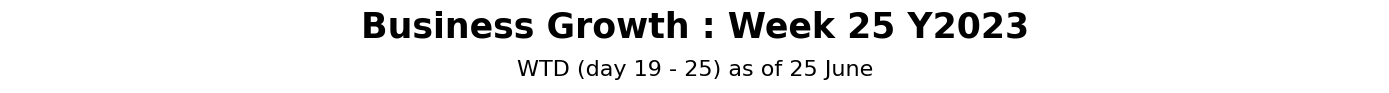

In [270]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Business Growth : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()